In [1]:
%pylab inline
import numpy as np
import pymc3 as pm
import theano.tensor as tt
import scipy as sp

%qtconsole

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# [ZeroInflatedGamma using pm.Mixture](https://stackoverflow.com/questions/42409761/pymc3-nuts-has-difficulty-sampling-from-a-hierarchical-zero-inflated-gamma-mode)

In [2]:
import pandas as pd
d = pd.read_csv('https://raw.githubusercontent.com/rmcelreath/mcelreath-koster-human-nature-2014/master/hunting.csv', sep=',')

In [3]:
d.head()

,month,day,year,id,age,kg.meat,hours,datatype
0,10,2.0,1981,3043,67,0.0,6.97,1.0
1,10,3.0,1981,3043,67,0.0,9.00,1.0
2,10,4.0,1981,3043,67,0.0,1.55,1.0
3,10,5.0,1981,3043,67,4.5,8.00,1.0
4,10,6.0,1981,3043,67,0.0,3.00,1.0


In [4]:
n_trip = len(d)
uni_id = d['id'].unique()
n_hunter = len(uni_id)
idx_ = d['id'].values
idx_hunter = np.zeros(idx_.size, dtype=int)
for i in range(n_hunter):
    idx_hunter[idx_==uni_id[i]]=i

y = d['kg.meat'].values
age = d['age'].values
age2 = sp.stats.zscore((d['age'].values)**2)
age3 = sp.stats.zscore((d['age'].values)**3)

In [5]:
from pymc3.distributions.dist_math import bound
from pymc3.math import logsumexp
class ZeroInflatedGamma(pm.Continuous):
    
    def __init__(self, pi, alpha, beta, *args, **kwargs):
        super(ZeroInflatedGamma, self).__init__(*args, **kwargs)
        self.alpha = alpha
        self.beta = beta
        self.gamma = pm.Gamma.dist(alpha, beta)
        self.pi = pi = tt.as_tensor_variable(pi)
        self.mode = self.gamma.mode
        
    def logp(self, value):
        pi = self.pi
        return bound(
                tt.switch(value > 0,
                tt.log(1 - pi) + self.gamma.logp(value),
                tt.log(pi)),
                value >= 0, pi > 0, pi < 1)

#     def logp(self, value):
#         w = tt.stack([self.pi, 1-self.pi])
#         return bound(logsumexp(tt.log(w) + self.gamma.logp(value), axis=-1).sum(),
#                      w > 0, w < 1, tt.allclose(w.sum(axis=-1), 1),
#                      broadcast_conditions=False)

#     def logp(self, value):
#         pi = self.pi
#         alpha = self.alpha
#         beta = self.beta
#         zeroidx = np.where(value==0)
#         gammidx = np.where(~(value==0))
#         gamma = pm.Gamma.dist(alpha[gammidx], beta[gammidx])
#         loggamma = tt.sum(tt.log(1 - pi[gammidx]) + gamma.logp(value[gammidx]))
#         logzero = tt.sum(tt.log(pi[zeroidx]))

#         return loggamma+logzero

In [14]:
def ZIGammalogp(pi, alpha, beta, yobs):
    zeroidx = np.where(yobs==0)
    gammidx = np.where(~(yobs==0))
    gamma = pm.Gamma.dist(alpha[gammidx], beta[gammidx])
    loggamma = tt.sum(tt.log(1 - pi[gammidx]) + gamma.logp(yobs[gammidx]))
    logzero = tt.sum(tt.log(pi[zeroidx]))
    
    return loggamma+logzero

In [22]:
def ZIGammalogp(pi, alpha, beta, yobs):
    gamma = pm.Gamma.dist(alpha, beta)
    return bound(
                tt.switch(tt.gt(yobs, 0.0),
                tt.log(1 - pi) + gamma.logp(yobs),
                tt.log(pi)),
                yobs >= 0.,
                pi > 0., pi < 1.)

In [23]:
jitter = 1e-6
Nd = 9
with pm.Model() as Vary9_model:
    # hyper-priors
    mu_a = pm.Normal('mu_a', mu=0., sd=100., shape=Nd)
    # covariance matrix
    sd_dist = pm.HalfCauchy.dist(beta=5.)
    packed_chol = pm.LKJCholeskyCov('chol_cov', eta=2, n=Nd, sd_dist=sd_dist)
    chol = pm.expand_packed_triangular(Nd, packed_chol, lower=True)
    #cov = tt.dot(chol, chol.T) + jitter * tt.eye(Nd)
    
    # transform an uncorrelated normal:
    vals_raw = pm.Normal('vals_raw', mu=0., sd=1., shape=(Nd, n_hunter))
    coeffs = pm.Deterministic('coeffs', mu_a[None, :]+tt.dot(chol, vals_raw).transpose())
    
    #coeffs = pm.MvNormal('coeffs', mu=mu_a, chol=chol, shape=(n_hunter, Nd))
    
    # linear function  
    mupi = coeffs[idx_hunter][:,0] \
         + coeffs[idx_hunter][:,1] * age \
         + coeffs[idx_hunter][:,2] * age2 \
         + coeffs[idx_hunter][:,3] * age3
    mualpha = coeffs[idx_hunter][:,4] + \
              coeffs[idx_hunter][:,5] * age + \
              coeffs[idx_hunter][:,6] * age2 + \
              coeffs[idx_hunter][:,7] * age3

    pi = pm.math.sigmoid(mupi)
    alpha = pm.math.exp(mualpha)
    beta = pm.math.exp(coeffs[idx_hunter][:,8])

#     y_obs = ZeroInflatedGamma('y_obs', pi, alpha, beta, observed=y) # 
    y_obs = pm.DensityDist('y_obs', ZIGammalogp,
                        observed={'pi':pi, 'alpha':alpha, 'beta':beta, 'yobs':y})

In [24]:
Vary9_model.test_point

{'chol_cov_cholesky_cov_packed__': array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.]),
 'mu_a': array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 'vals_raw': array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]])}

In [25]:
Vary9_model.basic_RVs[2].logp(Vary9_model.test_point)

array(-1215.7556794298055)

In [26]:
Vary9_model.logp(Vary9_model.test_point)

array(-57288.34556063814)

In [27]:
np.unique(alpha.tag.test_value)

array([ 1.])

In [28]:
njobs=2
n_init=200000
cb = [pm.callbacks.CheckParametersConvergence(tolerance=1e-2, diff='absolute', ),
      pm.callbacks.CheckParametersConvergence(tolerance=1e-2, diff='relative'),]

with Vary9_model:
#     v_params = pm.advi(n=200000)
#     start = pm.sample_vp(v_params, 1, progressbar=False)[0]
#     cov = np.power(Vary9_model.dict_to_array(v_params.stds), 2)

    random_seed = int(np.atleast_1d(-1)[0])
    approx = pm.fit(
            random_seed=random_seed,
            n=n_init, method='advi',
            callbacks=cb,
            progressbar=True,
            obj_optimizer=pm.adagrad_window(learning_rate=2e-4)
        )  # type: pm.MeanField
    start = approx.sample(draws=njobs)
    stds = approx.gbij.rmap(approx.std.eval())
    cov = Vary9_model.dict_to_array(stds) ** 2
    if njobs == 1:
        start = start[0]

Average Loss = inf:   0%|          | 95/200000 [00:01<42:11, 78.96it/s]      
Convergence archived at 100
Interrupted at 100 [0%]: Average Loss = 2.8043e+113


In [29]:
with Vary9_model:
#     start = pm.find_MAP()
#     step = pm.NUTS(scaling=start)
#     trace = pm.sample(2000, step=step, start=start, njobs=2)
    trace = pm.sample(3000, njobs=2, init='adapt_diag')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
  0%|          | 0/3500 [00:00<?, ?it/s]


JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/usr/lib/python3.5/runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    179         sys.exit(msg)
    180     main_globals = sys.modules["__main__"].__dict__
    181     if alter_argv:
    182         sys.argv[0] = mod_spec.origin
    183     return _run_code(code, main_globals, None,
--> 184                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.5/dist-packages/ipykernel_launcher.py')
    185 
    186 def run_module(mod_name, init_globals=None,
    187                run_name=None, alter_sys=False):
    188     """Execute a module's code without importing it

...........................................................................
/usr/lib/python3.5/runpy.py in _run_code(code=<code object <module> at 0x7f21b27fd9c0, file "/...3.5/dist-packages/ipykernel_launcher.py", line 5>, run_globals={'__builtins__': <module 'builtins' (built-in)>, '__cached__': '/usr/local/lib/python3.5/dist-packages/__pycache__/ipykernel_launcher.cpython-35.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.5/dist-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py'>, 'sys': <module 'sys' (built-in)>}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.5/dist-packages/ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x7f21b27fd9c0, file "/...3.5/dist-packages/ipykernel_launcher.py", line 5>
        run_globals = {'__builtins__': <module 'builtins' (built-in)>, '__cached__': '/usr/local/lib/python3.5/dist-packages/__pycache__/ipykernel_launcher.cpython-35.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.5/dist-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py'>, 'sys': <module 'sys' (built-in)>}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    472             return self.subapp.start()
    473         if self.poller is not None:
    474             self.poller.start()
    475         self.kernel.start()
    476         try:
--> 477             ioloop.IOLoop.instance().start()
    478         except KeyboardInterrupt:
    479             pass
    480 
    481 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/usr/local/lib/python3.5/dist-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    172             )
    173         return loop
    174     
    175     def start(self):
    176         try:
--> 177             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    178         except ZMQError as e:
    179             if e.errno == ETERM:
    180                 # quietly return on ETERM
    181                 pass

...........................................................................
/usr/local/lib/python3.5/dist-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    883                 self._events.update(event_pairs)
    884                 while self._events:
    885                     fd, events = self._events.popitem()
    886                     try:
    887                         fd_obj, handler_func = self._handlers[fd]
--> 888                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    889                     except (OSError, IOError) as e:
    890                         if errno_from_exception(e) == errno.EPIPE:
    891                             # Happens when the client closes the connection
    892                             pass

...........................................................................
/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': "with Vary9_model:\n#     start = pm.find_MAP()\n# ...ace = pm.sample(3000, njobs=2, init='adapt_diag')", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2017, 7, 10, 16, 7, 39, 93207, tzinfo=datetime.timezone.utc), 'msg_id': '4D96952BD01242C38766D3BBA82200CB', 'msg_type': 'execute_request', 'session': 'DB5960C467474DC8B2ABBB2A2DB1AFDC', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '4D96952BD01242C38766D3BBA82200CB', 'msg_type': 'execute_request', 'parent_header': {}})
    230             self.log.warn("Unknown message type: %r", msg_type)
    231         else:
    232             self.log.debug("%s: %s", msg_type, msg)
    233             self.pre_handler_hook()
    234             try:
--> 235                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'DB5960C467474DC8B2ABBB2A2DB1AFDC']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': "with Vary9_model:\n#     start = pm.find_MAP()\n# ...ace = pm.sample(3000, njobs=2, init='adapt_diag')", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2017, 7, 10, 16, 7, 39, 93207, tzinfo=datetime.timezone.utc), 'msg_id': '4D96952BD01242C38766D3BBA82200CB', 'msg_type': 'execute_request', 'session': 'DB5960C467474DC8B2ABBB2A2DB1AFDC', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '4D96952BD01242C38766D3BBA82200CB', 'msg_type': 'execute_request', 'parent_header': {}}
    236             except Exception:
    237                 self.log.error("Exception in message handler:", exc_info=True)
    238             finally:
    239                 self.post_handler_hook()

...........................................................................
/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'DB5960C467474DC8B2ABBB2A2DB1AFDC'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': "with Vary9_model:\n#     start = pm.find_MAP()\n# ...ace = pm.sample(3000, njobs=2, init='adapt_diag')", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2017, 7, 10, 16, 7, 39, 93207, tzinfo=datetime.timezone.utc), 'msg_id': '4D96952BD01242C38766D3BBA82200CB', 'msg_type': 'execute_request', 'session': 'DB5960C467474DC8B2ABBB2A2DB1AFDC', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '4D96952BD01242C38766D3BBA82200CB', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
/usr/local/lib/python3.5/dist-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code="with Vary9_model:\n#     start = pm.find_MAP()\n# ...ace = pm.sample(3000, njobs=2, init='adapt_diag')", silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    191 
    192         self._forward_input(allow_stdin)
    193 
    194         reply_content = {}
    195         try:
--> 196             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = "with Vary9_model:\n#     start = pm.find_MAP()\n# ...ace = pm.sample(3000, njobs=2, init='adapt_diag')"
        store_history = True
        silent = False
    197         finally:
    198             self._restore_input()
    199 
    200         if res.error_before_exec is not None:

...........................................................................
/usr/local/lib/python3.5/dist-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=("with Vary9_model:\n#     start = pm.find_MAP()\n# ...ace = pm.sample(3000, njobs=2, init='adapt_diag')",), **kwargs={'silent': False, 'store_history': True})
    528             )
    529         self.payload_manager.write_payload(payload)
    530 
    531     def run_cell(self, *args, **kwargs):
    532         self._last_traceback = None
--> 533         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ("with Vary9_model:\n#     start = pm.find_MAP()\n# ...ace = pm.sample(3000, njobs=2, init='adapt_diag')",)
        kwargs = {'silent': False, 'store_history': True}
    534 
    535     def _showtraceback(self, etype, evalue, stb):
    536         # try to preserve ordering of tracebacks and print statements
    537         sys.stdout.flush()

...........................................................................
/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell="with Vary9_model:\n#     start = pm.find_MAP()\n# ...ace = pm.sample(3000, njobs=2, init='adapt_diag')", store_history=True, silent=False, shell_futures=True)
   2678                 self.displayhook.exec_result = result
   2679 
   2680                 # Execute the user code
   2681                 interactivity = "none" if silent else self.ast_node_interactivity
   2682                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2683                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2684                 
   2685                 self.last_execution_succeeded = not has_raised
   2686 
   2687                 # Reset this so later displayed values do not modify the

...........................................................................
/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.With object>], cell_name='<ipython-input-29-9ca5ec75c500>', interactivity='none', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 7f20fe6bfcf8, executi..._before_exec=None error_in_exec=None result=None>)
   2782 
   2783         try:
   2784             for i, node in enumerate(to_run_exec):
   2785                 mod = ast.Module([node])
   2786                 code = compiler(mod, cell_name, "exec")
-> 2787                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x7f212adb4660, file "<ipython-input-29-9ca5ec75c500>", line 1>
        result = <ExecutionResult object at 7f20fe6bfcf8, executi..._before_exec=None error_in_exec=None result=None>
   2788                     return True
   2789 
   2790             for i, node in enumerate(to_run_interactive):
   2791                 mod = ast.Interactive([node])

...........................................................................
/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x7f212adb4660, file "<ipython-input-29-9ca5ec75c500>", line 1>, result=<ExecutionResult object at 7f20fe6bfcf8, executi..._before_exec=None error_in_exec=None result=None>)
   2842         outflag = True  # happens in more places, so it's easier as default
   2843         try:
   2844             try:
   2845                 self.hooks.pre_run_code_hook()
   2846                 #rprint('Running code', repr(code_obj)) # dbg
-> 2847                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x7f212adb4660, file "<ipython-input-29-9ca5ec75c500>", line 1>
        self.user_global_ns = {'ALLOW_THREADS': 1, 'Annotation': <class 'matplotlib.text.Annotation'>, 'Arrow': <class 'matplotlib.patches.Arrow'>, 'Artist': <class 'matplotlib.artist.Artist'>, 'AutoLocator': <class 'matplotlib.ticker.AutoLocator'>, 'Axes': <class 'matplotlib.axes._axes.Axes'>, 'AxisError': <class 'numpy.core._internal.AxisError'>, 'BUFSIZE': 8192, 'Button': <class 'matplotlib.widgets.Button'>, 'CLIP': 0, ...}
        self.user_ns = {'ALLOW_THREADS': 1, 'Annotation': <class 'matplotlib.text.Annotation'>, 'Arrow': <class 'matplotlib.patches.Arrow'>, 'Artist': <class 'matplotlib.artist.Artist'>, 'AutoLocator': <class 'matplotlib.ticker.AutoLocator'>, 'Axes': <class 'matplotlib.axes._axes.Axes'>, 'AxisError': <class 'numpy.core._internal.AxisError'>, 'BUFSIZE': 8192, 'Button': <class 'matplotlib.widgets.Button'>, 'CLIP': 0, ...}
   2848             finally:
   2849                 # Reset our crash handler in place
   2850                 sys.excepthook = old_excepthook
   2851         except SystemExit as e:

...........................................................................
/home/laoj/Documents/Github/Human_Learning/Miscellaneous/<ipython-input-29-9ca5ec75c500> in <module>()
      1 with Vary9_model:
      2 #     start = pm.find_MAP()
      3 #     step = pm.NUTS(scaling=start)
      4 #     trace = pm.sample(2000, step=step, start=start, njobs=2)
----> 5     trace = pm.sample(3000, njobs=2, init='adapt_diag')

...........................................................................
/home/laoj/Documents/Github/pymc3/pymc3/sampling.py in sample(draws=3500, step=<pymc3.step_methods.hmc.nuts.NUTS object>, init='adapt_diag', n_init=200000, start=[{'chol_cov_cholesky_cov_packed__': array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  ...,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.]), 'mu_a': array([ 177.05185064,  -80.78704199,   -1.320896...5.47986542,  -47.38733624,
        107.50238991]), 'vals_raw': array([[ 0.55856524,  0.0633975 , -0.45103332, .... -0.81805872,
        -2.29704826,  0.05156377]])}, {'chol_cov_cholesky_cov_packed__': array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  ...,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.]), 'mu_a': array([  43.04498999,  -98.19344266,  102.059361...0.69703374,  -71.13571433,
        -80.35717322]), 'vals_raw': array([[-1.1985541 , -1.0670495 , -0.50155572, ....  0.74124589,
        -1.14425704,  1.07470074]])}], trace=None, chain=0, njobs=2, tune=500, nuts_kwargs=None, step_kwargs=None, progressbar=True, model=<pymc3.model.Model object>, random_seed=-1, live_plot=False, discard_tuned_samples=True, live_plot_kwargs=None, **kwargs={})
    271     else:
    272         sample_func = _sample
    273 
    274     discard = tune if discard_tuned_samples else 0
    275 
--> 276     return sample_func(**sample_args)[discard:]
        sample_func = <function _mp_sample>
        sample_args = {'chain': 0, 'draws': 3500, 'live_plot': False, 'live_plot_kwargs': None, 'model': <pymc3.model.Model object>, 'njobs': 2, 'progressbar': True, 'random_seed': -1, 'start': [{'chol_cov_cholesky_cov_packed__': array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  ...,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.]), 'mu_a': array([ 177.05185064,  -80.78704199,   -1.320896...5.47986542,  -47.38733624,
        107.50238991]), 'vals_raw': array([[ 0.55856524,  0.0633975 , -0.45103332, .... -0.81805872,
        -2.29704826,  0.05156377]])}, {'chol_cov_cholesky_cov_packed__': array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  ...,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.]), 'mu_a': array([  43.04498999,  -98.19344266,  102.059361...0.69703374,  -71.13571433,
        -80.35717322]), 'vals_raw': array([[-1.1985541 , -1.0670495 , -0.50155572, ....  0.74124589,
        -1.14425704,  1.07470074]])}], 'step': <pymc3.step_methods.hmc.nuts.NUTS object>, ...}
        discard = 500
    277 
    278 
    279 def _sample(draws, step=None, start=None, trace=None, chain=0, tune=None,
    280             progressbar=True, model=None, random_seed=-1, live_plot=False,

...........................................................................
/home/laoj/Documents/Github/pymc3/pymc3/sampling.py in _mp_sample(**kwargs={'draws': 3500, 'live_plot': False, 'live_plot_kwargs': None, 'model': <pymc3.model.Model object>, 'step': <pymc3.step_methods.hmc.nuts.NUTS object>, 'trace': None, 'tune': 500})
    457     pbars = [kwargs.pop('progressbar')] + [False] * (njobs - 1)
    458     traces = Parallel(n_jobs=njobs)(delayed(_sample)(chain=chains[i],
    459                                                      progressbar=pbars[i],
    460                                                      random_seed=rseed[i],
    461                                                      start=start_vals[i],
--> 462                                                      **kwargs) for i in range(njobs))
        kwargs = {'draws': 3500, 'live_plot': False, 'live_plot_kwargs': None, 'model': <pymc3.model.Model object>, 'step': <pymc3.step_methods.hmc.nuts.NUTS object>, 'trace': None, 'tune': 500}
        njobs = 2
    463     return merge_traces(traces)
    464 
    465 
    466 def stop_tuning(step):

...........................................................................
/usr/local/lib/python3.5/dist-packages/joblib/parallel.py in __call__(self=Parallel(n_jobs=2), iterable=<generator object _mp_sample.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=2)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Mon Jul 10 18:07:45 2017
PID: 26458                                   Python 3.5.2: /usr/bin/python3
...........................................................................
/usr/local/lib/python3.5/dist-packages/joblib/parallel.py in __call__(self=<joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _sample>, (), {'chain': 0, 'draws': 3500, 'live_plot': False, 'live_plot_kwargs': None, 'model': <pymc3.model.Model object>, 'progressbar': True, 'random_seed': 139836674, 'start': {'chol_cov_cholesky_cov_packed__': array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  ...,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.]), 'mu_a': array([ 177.05185064,  -80.78704199,   -1.320896...5.47986542,  -47.38733624,
        107.50238991]), 'vals_raw': array([[ 0.55856524,  0.0633975 , -0.45103332, .... -0.81805872,
        -2.29704826,  0.05156377]])}, 'step': <pymc3.step_methods.hmc.nuts.NUTS object>, 'trace': None, ...})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/usr/local/lib/python3.5/dist-packages/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _sample>
        args = ()
        kwargs = {'chain': 0, 'draws': 3500, 'live_plot': False, 'live_plot_kwargs': None, 'model': <pymc3.model.Model object>, 'progressbar': True, 'random_seed': 139836674, 'start': {'chol_cov_cholesky_cov_packed__': array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  ...,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.]), 'mu_a': array([ 177.05185064,  -80.78704199,   -1.320896...5.47986542,  -47.38733624,
        107.50238991]), 'vals_raw': array([[ 0.55856524,  0.0633975 , -0.45103332, .... -0.81805872,
        -2.29704826,  0.05156377]])}, 'step': <pymc3.step_methods.hmc.nuts.NUTS object>, 'trace': None, ...}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/home/laoj/Documents/Github/pymc3/pymc3/sampling.py in _sample(draws=3500, step=<pymc3.step_methods.hmc.nuts.NUTS object>, start={'chol_cov_cholesky_cov_packed__': array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  ...,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.]), 'mu_a': array([ 177.05185064,  -80.78704199,   -1.320896...5.47986542,  -47.38733624,
        107.50238991]), 'vals_raw': array([[ 0.55856524,  0.0633975 , -0.45103332, .... -0.81805872,
        -2.29704826,  0.05156377]])}, trace=None, chain=0, tune=500, progressbar=True, model=<pymc3.model.Model object>, random_seed=139836674, live_plot=False, live_plot_kwargs=None, **kwargs={})
    286                             tune, model, random_seed)
    287     if progressbar:
    288         sampling = tqdm(sampling, total=draws)
    289     try:
    290         strace = None
--> 291         for it, strace in enumerate(sampling):
        it = undefined
        strace = None
        sampling =   0%|          | 0/3500 [00:00<?, ?it/s]
    292             if live_plot:
    293                 if live_plot_kwargs is None:
    294                     live_plot_kwargs = {}
    295                 if it >= skip_first:

...........................................................................
/usr/local/lib/python3.5/dist-packages/tqdm/_tqdm.py in __iter__(self=  0%|          | 0/3500 [00:00<?, ?it/s])
    857             except AttributeError:
    858                 raise TqdmDeprecationWarning("""\
    859 Please use `tqdm_gui(...)` instead of `tqdm(..., gui=True)`
    860 """, fp_write=getattr(self.fp, 'write', sys.stderr.write))
    861 
--> 862             for obj in iterable:
        obj = undefined
        iterable = <generator object _iter_sample>
    863                 yield obj
    864                 # Update and print the progressbar.
    865                 # Note: does not call self.update(1) for speed optimisation.
    866                 n += 1

...........................................................................
/home/laoj/Documents/Github/pymc3/pymc3/sampling.py in _iter_sample(draws=3500, step=<pymc3.step_methods.hmc.nuts.NUTS object>, start={'chol_cov_cholesky_cov_packed__': array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  ...,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.]), 'mu_a': array([ 177.05185064,  -80.78704199,   -1.320896...5.47986542,  -47.38733624,
        107.50238991]), 'vals_raw': array([[ 0.55856524,  0.0633975 , -0.45103332, .... -0.81805872,
        -2.29704826,  0.05156377]])}, trace=None, chain=0, tune=500, model=<pymc3.model.Model object>, random_seed=139836674)
    384     try:
    385         for i in range(draws):
    386             if i == tune:
    387                 step = stop_tuning(step)
    388             if step.generates_stats:
--> 389                 point, states = step.step(point)
        point = {'chol_cov_cholesky_cov_packed__': array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  ...,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.]), 'mu_a': array([ 177.05185064,  -80.78704199,   -1.320896...5.47986542,  -47.38733624,
        107.50238991]), 'vals_raw': array([[ 0.55856524,  0.0633975 , -0.45103332, .... -0.81805872,
        -2.29704826,  0.05156377]])}
        states = undefined
        step.step = <bound method ArrayStepShared.step of <pymc3.step_methods.hmc.nuts.NUTS object>>
    390                 if strace.supports_sampler_stats:
    391                     strace.record(point, states)
    392                 else:
    393                     strace.record(point)

...........................................................................
/home/laoj/Documents/Github/pymc3/pymc3/step_methods/arraystep.py in step(self=<pymc3.step_methods.hmc.nuts.NUTS object>, point={'chol_cov_cholesky_cov_packed__': array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  ...,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.]), 'mu_a': array([ 177.05185064,  -80.78704199,   -1.320896...5.47986542,  -47.38733624,
        107.50238991]), 'vals_raw': array([[ 0.55856524,  0.0633975 , -0.45103332, .... -0.81805872,
        -2.29704826,  0.05156377]])})
    147             share.set_value(point[var])
    148 
    149         bij = DictToArrayBijection(self.ordering, point)
    150 
    151         if self.generates_stats:
--> 152             apoint, stats = self.astep(bij.map(point))
        apoint = undefined
        stats = undefined
        self.astep = <bound method NUTS.astep of <pymc3.step_methods.hmc.nuts.NUTS object>>
        bij.map = <bound method DictToArrayBijection.map of <pymc3.blocking.DictToArrayBijection object>>
        point = {'chol_cov_cholesky_cov_packed__': array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  ...,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.]), 'mu_a': array([ 177.05185064,  -80.78704199,   -1.320896...5.47986542,  -47.38733624,
        107.50238991]), 'vals_raw': array([[ 0.55856524,  0.0633975 , -0.45103332, .... -0.81805872,
        -2.29704826,  0.05156377]])}
    153             return bij.rmap(apoint), stats
    154         else:
    155             apoint = self.astep(bij.map(point))
    156             return bij.rmap(apoint)

...........................................................................
/home/laoj/Documents/Github/pymc3/pymc3/step_methods/hmc/nuts.py in astep(self=<pymc3.step_methods.hmc.nuts.NUTS object>, q0=array([  5.58565240e-01,   6.33975016e-02,  -4.5...5479865e+02,  -4.73873362e+01,   1.07502390e+02]))
    179         p0 = self.potential.random()
    180         v0 = self.compute_velocity(p0)
    181         start_energy = self.compute_energy(q0, p0)
    182         if not np.all(np.isfinite(start_energy)):
    183             raise ValueError('Bad initial energy: %s. The model '
--> 184                              'might be misspecified.' % start_energy)
        start_energy = array(nan)
    185 
    186         if not self.adapt_step_size:
    187             step_size = self.step_size
    188         elif self.tune:

ValueError: Bad initial energy: nan. The model might be misspecified.
___________________________________________________________________________

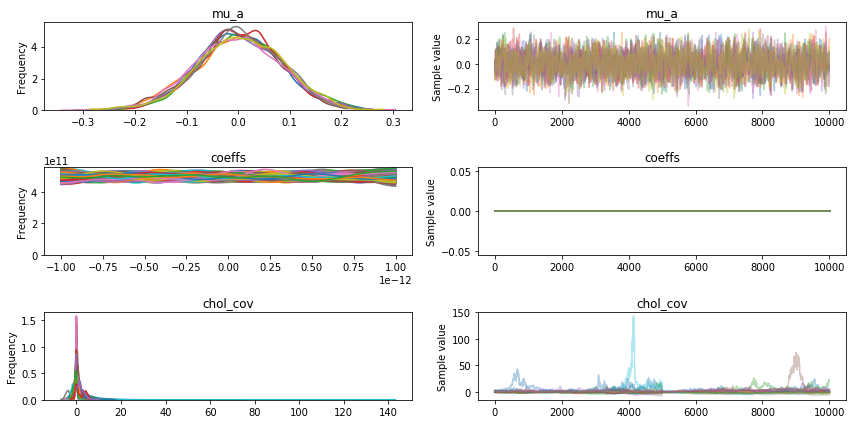

In [9]:
pm.traceplot(Vary9_trace, varnames=['mu_a', 'coeffs', 'chol_cov'], combined=True);

# [NUTS and HamiltonianMC won't begin sampling](https://github.com/pymc-devs/pymc3/issues/2204)

In [33]:
import pandas as pd
tbltmp = pd.read_csv('sndata.txt', decimal=',', names=['z','y','s'])

In [3]:
z = np.asarray(tbltmp['z'],dtype='float')
y = np.asarray(tbltmp['y'],dtype='float')
s = np.asarray(tbltmp['s'],dtype='float')

In [4]:
def simpson(f, a, b, n):
    h = (b - a)/n
    k = 0.0
    x = a + h
    for i in range(1, int(n/2 + 1)):
        k += 4 * f(x)
        x += 2 * h
    
    x = a + 2.0 * h
    for i in range(1, int(n/2)):
        k += 2 * f(x)
        x += 2 * h
    return (h/3)*(f(a) + f(b) + k)

M=1.
L=1.
H=50.
def comovingDistance(z):
    return 1.0/(np.sqrt((M*(1.0+z)**3) + ((1.-M-L)*(1.+z)**2) + L))
tmp = simpson(comovingDistance, 0.000001, z, 100)
print(tmp[:20])

[ 0.59273335  0.0763006   0.22820555  0.47023243  0.30761401  0.82811595
  0.84715776  0.33315435  0.6507904   0.48631832  0.02002207  0.83979104
  0.34507393  0.25252369  0.80544539  0.41158603  0.1863916   0.69453021
  0.6777744   0.57093408]


In [25]:
c=10
with pm.Model() as model:
    M = pm.Uniform('M', 0.0, 3.0)
    L = pm.Uniform('L', 0.0, 3.0)
    H = pm.Uniform('H', 0.0, 100.0)
    
    #comovingDistance = 1.0/(tt.sqrt((M*(1.0+z)**3) + ((1.-M-L)*(1.+z)**2) + L))
    
    mean = 5.0 * tt.log10((1.0 + z) * c/(H) * (simpson(comovingDistance, 0.000001, z, 100)) / (10.0 ** (-5.0)))
    
    likelihood = pm.Normal('fit', mu = mean, sd = s, observed = y)
    
    trace = pm.sample(3000)

TypeError: 'TensorVariable' object is not callable

# [Theano MissingInputError when running model with start argument in sample](https://github.com/pymc-devs/pymc3/issues/2109)

# [NaN model.logp](https://github.com/pymc-devs/pymc3/issues/2066#issuecomment-296258521)

In [6]:
import theano.tensor as tt
import pandas as pd
import numpy as np
import pickle
import pymc3 as pm
import theano.tensor as tt
from theano import scan
import theano
floatX = "float32"

from pymc3.distributions import continuous
from pymc3.distributions import distribution

class CAR(distribution.Continuous):
    """
    Conditional Autoregressive (CAR) distribution. Ref paper: https://www.ncbi.nlm.nih.gov/pubmed/12926715
    """

    def __init__(self, n_neigh, a, tau, lambda_par, *args, **kwargs):
        super(CAR, self).__init__(*args, **kwargs)
        self.a = tt.as_tensor_variable(a)
        self.n_neigh = tt.as_tensor_variable(n_neigh)
        self.tau = tau
        self.lambda_par = lambda_par
        self.mode = 0.

    def logp(self, x):
        denom = 1 - self.lambda_par + self.lambda_par * self.n_neigh
        tau = self.tau * denom
        num = self.lambda_par / denom

        mu_w = num * tt.sum(x * self.a, axis=1)  # tt.sum(x*a, axis=1)/tt.sum(w, axis=1)
        return tt.sum(continuous.Normal.dist(mu=mu_w, sd=tau).logp(x))


#LOAD DATA
with open('bug.pkl', "rb") as input_file:
    weights_df = pickle.load(input_file)
    X = pickle.load(input_file)
    y = pickle.load(input_file)
    
N = weights_df.values.shape[0]
amat = weights_df.values

n_neighbours = amat.sum(axis=1)

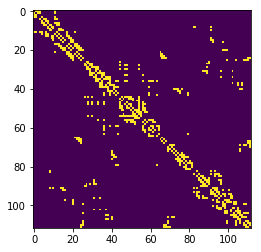

In [7]:
imshow(amat);

In [15]:
with pm.Model() as unpooled_model:
    # define priors, use Normal for Ridge (sd=100, weakly informative)
    b0 = pm.Normal('intercept', mu=5.4, tau=0.5)
    b1 = pm.Normal('b1_mdist_daily', mu=1, tau=1.0E-6)
    
    # random effect precision parameter
    tau = pm.Normal('tau', mu=0, tau=1.0E-6)#.Gamma('tau', alpha=0.001, beta=0.001)##
    
    # strength of spatial correlation
    p_ = pm.Normal('p_', mu=0, sd=100)
    # p_ = pm.Flat('p_')
    p = pm.Deterministic('p', pm.math.invlogit(p_))
    #Jac_adj = pm.Potential('Jac_adj', tt.log(p)+tt.log(1-p))
    #p = pm.Uniform('p', lower=0.0, upper=1.0, testval=0.9)
    
    phi = CAR('mu_phi', n_neigh=n_neighbours, a=amat, tau=tau, lambda_par=p, shape=N)
    
    # define linear model
    mu = tt.exp( b0 + b1 * X['mdist_daily'] + phi) # 
    #a = pm.HalfCauchy(name='alpha', beta=10, testval=1.) 
    a = pm.Normal('alpha', mu=5.2, sd=0.5)
    home_points = pm.NegativeBinomial('home_points', mu=mu, observed=y, alpha=a)


In [16]:
with unpooled_model:
    unpooled_trace = pm.sample(2000, tune=1000, njobs=2, nuts_kwargs={'target_accept': .95})

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
  0%|          | 0/200000 [00:00<?, ?it/s]/usr/local/lib/python3.5/dist-packages/numpy/lib/function_base.py:3858: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
Average ELBO = -790.31: 100%|██████████| 200000/200000 [00:38<00:00, 5137.01it/s]   
Finished [100%]: Average ELBO = -791.86
 86%|████████▌ | 1722/2000 [00:21<00:03, 84.00it/s]/usr/local/lib/python3.5/dist-packages/pymc3/step_methods/hmc/nuts.py:247: UserWarning: Chain 1 contains diverging samples after tuning. If increasing `target_accept` doesn't help, try to reparameterize.
  "try to reparameterize." % chain)
100%|█████████▉| 1993/2000 [00:24<00:00, 82.81it/s]/usr/local/lib/python3.5/dist-packages/pymc3/step_methods/hmc/nuts.py:247: UserWarning: Chain 0 contains diverging samples after tuning. If increasing `target_accept` doesn't help, try to reparameterize.
  "try to reparameterize." % chain)
100%|██████████| 2000/2000 [00:24<00:00,

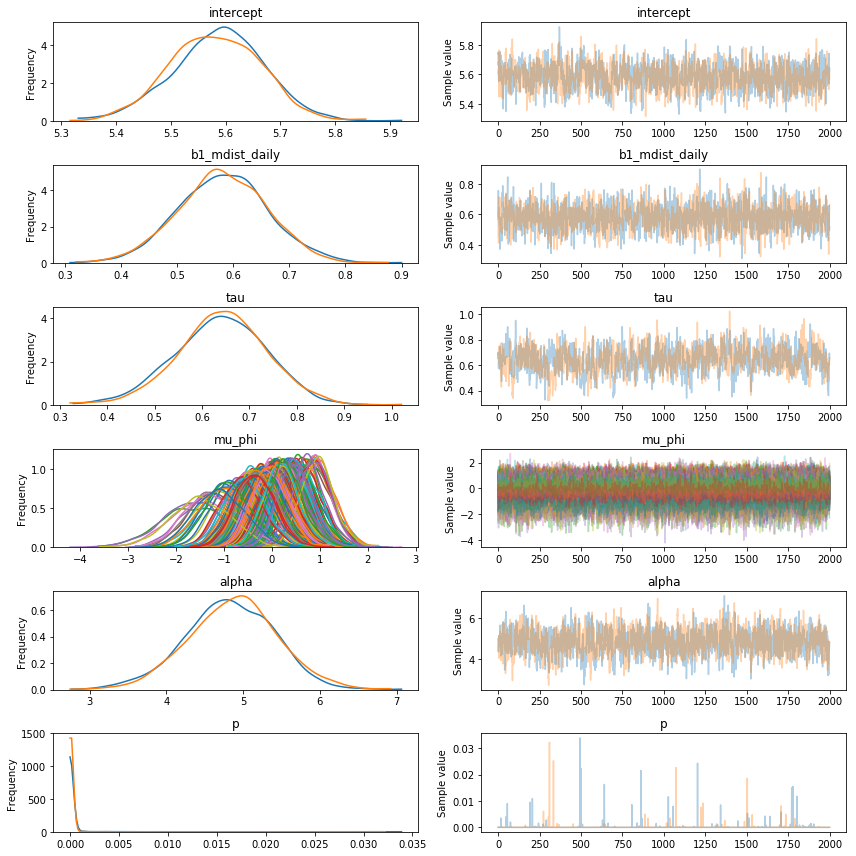

In [17]:
pm.traceplot(unpooled_trace);

100%|██████████| 500/500 [00:05<00:00, 92.62it/s] 


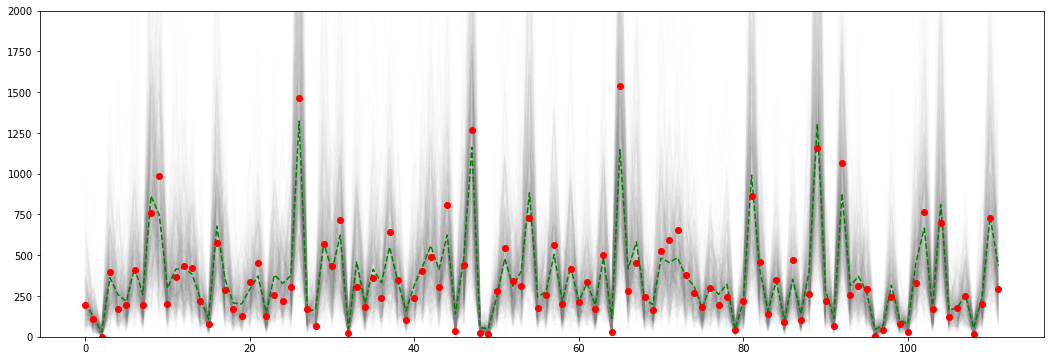

In [21]:
ppc = pm.sample_ppc(unpooled_trace, model=unpooled_model, samples=500)
plt.figure(figsize=(18,6))
plot(ppc['home_points'].T, color='gray', alpha=.01)
plot(ppc['home_points'].mean(axis=0), '--g')
plot(y, 'or')
ylim(0,2000);

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -758.25: 100%|██████████| 200000/200000 [01:01<00:00, 3250.40it/s]
Finished [100%]: Average ELBO = -758.29
100%|█████████▉| 1997/2000 [00:25<00:00, 93.00it/s] /Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:244: UserWarning: Chain 0 contains diverging samples after tuning. If increasing `target_accept` doesn't help, try to reparameterize.
  "try to reparameterize." % chain)
100%|██████████| 2000/2000 [00:25<00:00, 79.17it/s]
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:244: UserWarning: Chain 1 contains diverging samples after tuning. If increasing `target_accept` doesn't help, try to reparameterize.
  "try to reparameterize." % chain)


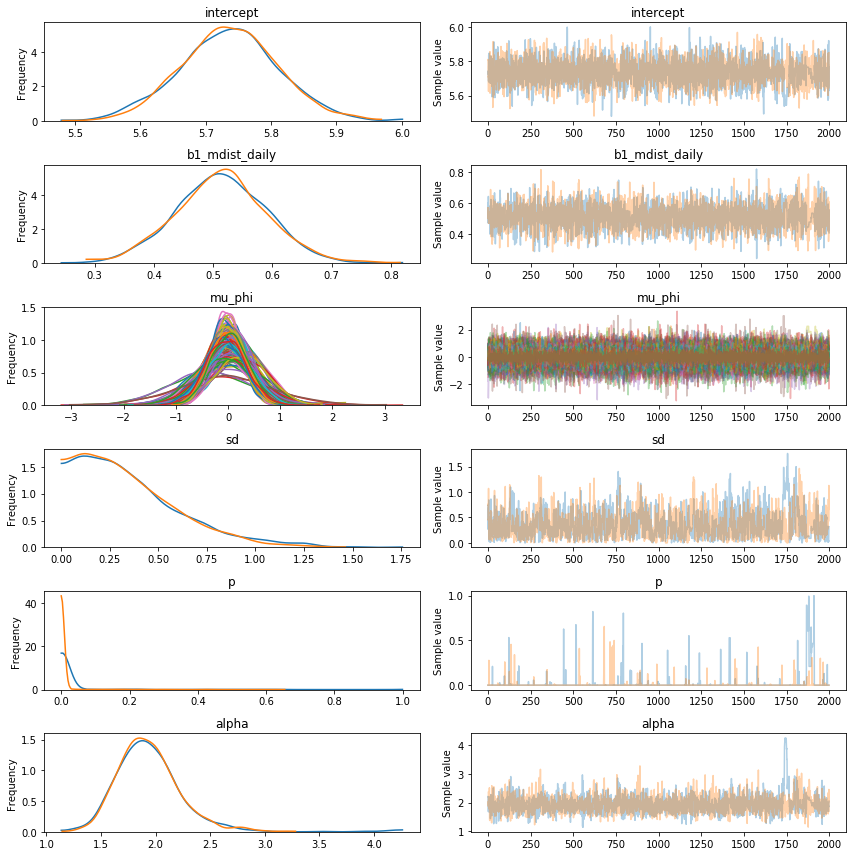

In [27]:
import theano.sparse
import scipy.sparse
from pymc3.distributions import Continuous
from pymc3.distributions.dist_math import bound

class CAR2(Continuous):
    def __init__(self, alpha, adjacency, *args, **kwargs):
        if not isinstance(adjacency, np.ndarray):
            raise ValueError("Adjacency matrix is not an ndarray.")
        n, m = adjacency.shape
        if n != m or np.any(adjacency != adjacency.T):
            raise ValueError('Adjacency matrix must be symmetric.')
        if 'shape' in kwargs and kwargs['shape'] == n:
            raise ValueError('Invalid shape: Must match matrix dimension.')
        kwargs['shape'] = n
        super(CAR2, self).__init__(*args, **kwargs)
        self.n = n
        self.alpha = tt.as_tensor_variable(alpha)
        adjacency_sparse = scipy.sparse.csr_matrix(adjacency)
        self.adjacency = theano.sparse.as_sparse_variable(adjacency_sparse)
        self.neighbors = tt.as_tensor_variable(adjacency.sum(0))
        self.mean = tt.zeros(n)
        self.median = self.mean
        adj = adjacency.astype('d').copy()
        sqrt_neighbors = 1 / np.sqrt(adjacency.sum(0))
        adj[:] *= sqrt_neighbors[:, None]
        adj[:] *= sqrt_neighbors[None, :]
        self.eigs = scipy.linalg.eigvalsh(adj)

    def logp(self, x):
        Wx = theano.sparse.dot(self.adjacency, x.reshape((self.n, 1)))
        tau_dot_x = self.neighbors * x - self.alpha * Wx.ravel()
        logdet = tt.log(1 - self.alpha * self.eigs).sum()
        logp = 0.5 * (logdet - tt.dot(x, tau_dot_x))
        return bound(logp, self.alpha > 0, self.alpha < 1)

with pm.Model() as model2:
    b0 = pm.Normal('intercept', mu=5.4, sd=2)
    b1 = pm.Cauchy('b1_mdist_daily', alpha=0, beta=2)

    # random effect precision parameter
    sd = pm.HalfCauchy('sd', beta=2)
    # strength of spatial correlation
    p_ = pm.Normal('p_', mu=0, sd=100)
    p = pm.Deterministic('p', pm.math.invlogit(p_))
    phi = CAR2('mu_phi', alpha=p, adjacency=amat)
    
    mu = tt.exp(b0 + b1 * X['mdist_daily'] + sd * phi)
    alpha = pm.HalfCauchy(name='alpha', beta=2)
    home_points = pm.NegativeBinomial('home_points', mu=mu, alpha=alpha, observed=y)
    
    unpooled_trace2 = pm.sample(2000, tune=1000, njobs=2)

pm.traceplot(unpooled_trace2);

100%|██████████| 500/500 [00:13<00:00, 37.56it/s]


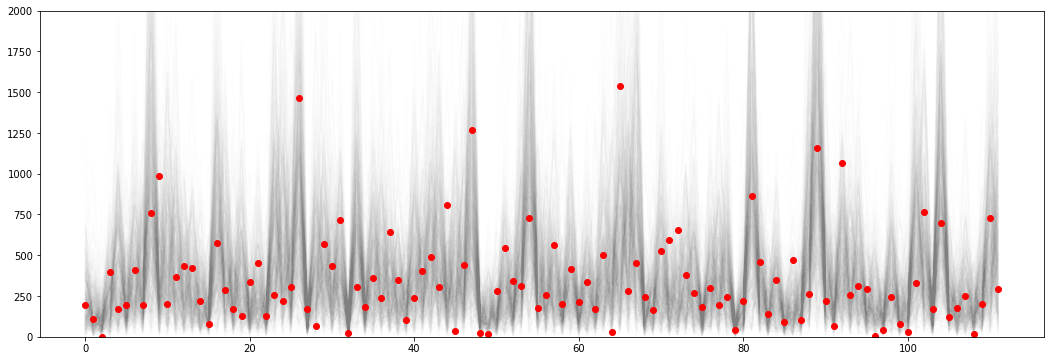

In [30]:
ppc = pm.sample_ppc(unpooled_trace2, model=model2, samples=500)
plt.figure(figsize=(18,6))
plot(ppc['home_points'].T, color='gray', alpha=.01)
plot(y, 'or')
ylim(0,2000);

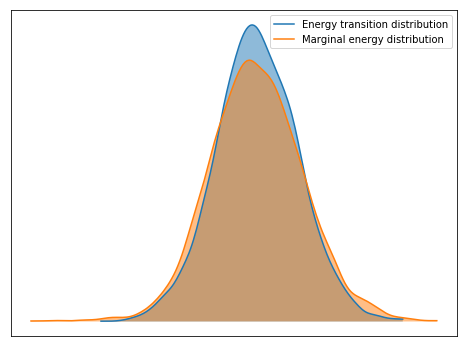

In [28]:
pm.energyplot(trace=unpooled_trace);

In [29]:
unpooled_trace['diverging'].nonzero()

(array([   5,   11,   29,   31,   93,   99,  130,  133,  139,  160,  170,
         199,  218,  228,  243,  267,  294,  295,  296,  319,  339,  348,
         349,  363,  386,  387,  394,  404,  435,  441,  454,  494,  528,
         532,  542,  582,  606,  624,  639,  645,  657,  675,  678,  688,
         700,  707,  709,  712,  716,  725,  775,  779,  787,  792,  805,
         813,  814,  829,  856,  905,  909,  920,  932,  934,  955,  963,
         967,  977,  993, 1014, 1020, 1043, 1096, 1097, 1098, 1106, 1114,
        1128, 1178, 1196, 1198, 1235, 1284, 1287, 1292, 1298, 1307, 1313,
        1315, 1355, 1356, 1423, 1437, 1444, 1527, 1533, 1534, 1546, 1547,
        1560, 1585, 1603, 1611, 1638, 1641, 1660, 1677, 1693, 1694, 1707,
        1723, 1754, 1790, 1809, 1810, 1821, 1841, 1843, 1857, 1865, 1885,
        1891, 1912, 1919, 1921, 1928, 1960, 1961, 2001, 2005, 2007, 2016,
        2022, 2023, 2026, 2036, 2047, 2062, 2071, 2075, 2080, 2083, 2085,
        2090, 2092, 2095, 2102, 2105, 

# [Categorical switchpoint](https://github.com/pymc-devs/pymc3/issues/2025)

In [2]:
# Data has 2 trials/independent runs, each with 500 observations (which can be 0, 1 or 2)
# Data switches from uniform probabilities to (1/6,2/3,1/6) at 250 on both trials
import theano

n=600
data = np.zeros((2,n))
swpoint = 250
data[0, :swpoint] = np.random.choice(np.arange(3), size = swpoint, p = [1/3, 1/3, 1/3])
data[0, swpoint:] = np.random.choice(np.arange(3), size = n-swpoint, p =  [1/6, 2/3, 1/6])
data[1, :swpoint] = np.random.choice(np.arange(3), size = swpoint, p =  [1/3, 1/3, 1/3])
data[1, swpoint:] = np.random.choice(np.arange(3), size = n-swpoint, p =  [1/6, 2/3, 1/6])

with pm.Model() as model:
    # 2 emission 'states', each with 3 possible emissions
    p = pm.Dirichlet('p', np.ones(3), shape = (2, 3))
    switchpoint = pm.Uniform('switchpoint', lower = 0, upper = n)
    swvect = tt.switch(switchpoint >= np.arange(n), 0, 1)

    def logp(value):
        m = tt.cast(value, 'int32')
        p0 = p[swvect, m[0,:]]
        p1 = p[swvect, m[1,:]]
        return tt.sum(tt.log(p0)) + tt.sum(tt.log(p1)) 
    
    obs = pm.DensityDist('obs', logp, observed={'value': data})
    
    trace1 = pm.sample(1e5, njobs=2, step=pm.Metropolis())
    
    # ADVI
    s = theano.shared(pm.floatX(1))
    inference = pm.ADVI(cost_part_grad_scale=s)
    # ADVI has nearly converged
    pm.fit(n=20000, method=inference)
    # It is time to set `s` to zero
    s.set_value(0)
    approx = inference.fit(n=10000)

    trace2 = pm.sample_approx(approx, 3000)
    elbos1 = -inference.hist
    
    trace3 = pm.sample(3e3, njobs=2, tune=1000)

100%|██████████| 100500/100500.0 [01:51<00:00, 902.42it/s] 
Average Loss = 1,193.3: 100%|██████████| 20000/20000 [00:05<00:00, 3468.55it/s]
Finished [100%]: Average Loss = 1,193.2
Average Loss = 1,193.9: 100%|██████████| 10000/10000 [00:02<00:00, 3495.72it/s]
Finished [100%]: Average Loss = 1,193.9
Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 1,195.3:   5%|▌         | 10431/200000 [00:03<00:56, 3367.72it/s]
Convergence archived at 10500
Interrupted at 10,500 [5%]: Average Loss = 1,237.8
 99%|█████████▉| 3972/4000.0 [57:43<00:15,  1.81it/s]    /Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:255: UserWarning: Chain 1 reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
  'reparameterize.' % chain)
100%|██████████| 4000/4000.0 [57:58<00:00,  1.88it/s]/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/pymc3/step_methods/hmc/nu

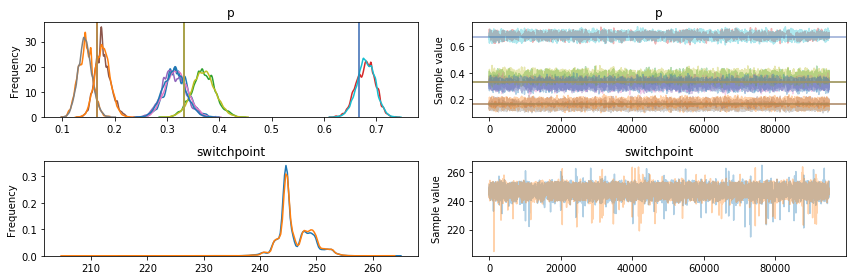

In [3]:
pm.traceplot(trace1[5000:], lines={'p':[1/3, 1/3, 1/3, 1/6, 2/3, 1/6]});

ADVI and NUTS does not perform as well

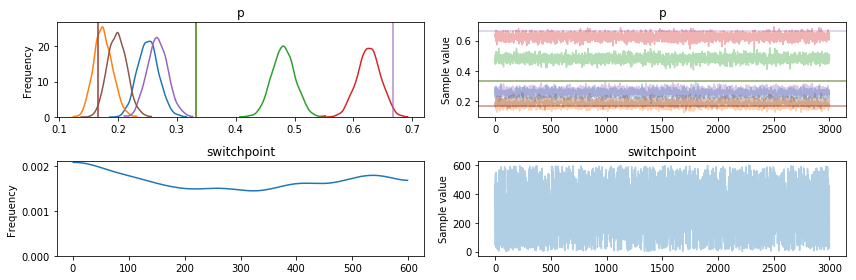

In [4]:
pm.traceplot(trace2, lines={'p':[1/3, 1/3, 1/3, 1/6, 2/3, 1/6]});

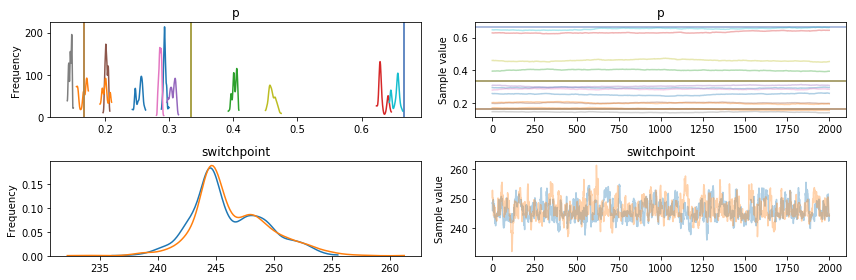

In [5]:
pm.traceplot(trace3[1000:], lines={'p':[1/3, 1/3, 1/3, 1/6, 2/3, 1/6]});

# [Conditional Autoregressive (CAR) model](http://glau.ca/?p=340)

In [6]:
import numpy as np

county = np.array(["skye_lochalsh", "banff_buchan", "caithness,berwickshire", "ross_cromarty", "orkney", "moray", "shetland", "lochaber", "gordon", "western_isles", "sutherland", "nairn", "wigtown", "NE.fife", "kincardine", "badenoch", "ettrick", "inverness", "roxburgh", "angus", "aberdeen", "argyll_bute", "clydesdale", "kirkcaldy", "dunfermline", "nithsdale", "east_lothian", "perth_kinross", "west_lothian", "cumnock_doon", " stewartry", " midlothian", "stirling", "kyle_carrick", "inverclyde", "cunninghame", "monklands", "dumbarton", "clydebank", "renfrew", "falkirk", "clackmannan", "motherwell", "edinburgh", "kilmarnock", "east_kilbride", "hamilton", "glasgow", "dundee", "cumbernauld", "bearsden", "eastwood", "strathkelvin", "tweeddale", "annandale"])

O = np.array([9, 39, 11, 9, 15, 8, 26, 7, 6, 20, 13, 5, 3, 8, 17, 9, 2, 7, 9, 7, 16, 31, 11, 7, 19, 15, 7, 10, 16, 11, 5, 3, 7, 8, 11, 9, 11, 8, 6, 4, 10, 8, 2, 6, 19, 3, 2, 3, 28, 6, 1, 1, 1, 1, 0, 0])

N = len(O)

E = np.array([1.4, 8.7, 3.0, 2.5, 4.3, 2.4, 8.1, 2.3, 2.0, 6.6, 4.4, 1.8, 1.1, 3.3, 7.8, 4.6, 1.1, 4.2, 5.5, 4.4, 10.5, 22.7, 8.8, 5.6, 15.5, 12.5, 6.0, 9.0, 14.4, 10.2, 4.8, 2.9, 7.0, 8.5, 12.3, 10.1, 12.7, 9.4, 7.2, 5.3, 18.8, 15.8, 4.3, 14.6, 50.7, 8.2, 5.6, 9.3, 88.7, 19.6, 3.4, 3.6, 5.7, 7.0, 4.2, 1.8])

logE = np.log(E)

aff = np.array([16, 16, 10, 24, 10, 24, 10, 7, 7, 16, 7, 16, 10, 24, 7, 16, 10, 7, 7, 10, 7, 16, 10, 7, 1, 1, 7, 7, 10, 10, 7, 24, 10, 7, 7, 0, 10, 1, 16, 0, 1, 16, 16, 0, 1, 7, 1, 1, 0, 1, 1, 0, 1, 1, 16, 10])/10.

num = np.array([4, 2, 2, 3, 5, 2, 5, 1,  6, 4, 4, 3, 4, 3, 3, 6, 6, 6 ,5, 3, 3, 2, 6, 8, 3, 4, 4, 4,11,  6, 7, 4, 4, 9, 5, 4, 5, 6, 5, 5, 7, 6, 4, 5, 4, 6, 6, 4, 9, 3, 4, 4, 4, 5, 5, 6])

adj = np.array([[5, 9,11,19],
[7,10],
[6,12],
[18,20,28],
[1,11,12,13,19],
[3, 8],
[2,10,13,16,17],
[6],
[1,11,17,19,23,29],
[2, 7,16,22],
[1, 5, 9,12],
[3, 5,11],
[5, 7,17,19],
[31,32,35],
[25,29,50],
[7,10,17,21,22,29],
[7, 9,13,16,19,29],
[4,20,28,33,55,56],
[1, 5, 9,13,17],
[4,18,55],
[16,29,50],
[10,16],
[9,29,34,36,37,39],
[27,30,31,44,47,48,55,56],
[15,26,29],
[25,29,42,43],
[24,31,32,55],
[4,18,33,45],
[9,15,16,17,21,23,25,26,34,43,50],
[24,38,42,44,45,56],
[14,24,27,32,35,46,47],
[14,27,31,35],
[18,28,45,56],
[23,29,39,40,42,43,51,52,54],
[14,31,32,37,46],
[23,37,39,41],
[23,35,36,41,46],
[30,42,44,49,51,54],
[23,34,36,40,41],
[34,39,41,49,52],
[36,37,39,40,46,49,53],
[26,30,34,38,43,51],
[26,29,34,42],
[24,30,38,48,49],
[28,30,33,56],
[31,35,37,41,47,53],
[24,31,46,48,49,53],
[24,44,47,49],
[38,40,41,44,47,48,52,53,54],
[15,21,29],
[34,38,42,54],
[34,40,49,54],
[41,46,47,49],
[34,38,49,51,52],
[18,20,24,27,56],
[18,24,30,33,45,55]])

# Change to Python indexing (i.e. -1)
for i in range(len(adj)):
    for j in range(len(adj[i])):
        adj[i][j] = adj[i][j]-1


weights = np.array([[1,1,1,1],
[1,1],
[1,1],
[1,1,1],
[1,1,1,1,1],
[1, 1],
[1,1,1,1,1],
[1],
[1,1,1,1,1,1],
[1, 1,1,1],
[1, 1, 1,1],
[1, 1,1],
[1, 1,1,1],
[1,1,1],
[1,1,1],
[1,1,1,1,1,1],
[1, 1,1,1,1,1],
[1,1,1,1,1,1],
[1, 1, 1,1,1],
[1,1,1],
[1,1,1],
[1,1],
[1,1,1,1,1,1],
[1,1,1,1,1,1,1,1],
[1,1,1],
[1,1,1,1],
[1,1,1,1],
[1,1,1,1],
[1,1,1,1,1,1,1,1,1,1,1],
[1,1,1,1,1,1],
[1,1,1,1,1,1,1],
[1,1,1,1],
[1,1,1,1],
[1,1,1,1,1,1,1,1,1],
[1,1,1,1,1],
[1,1,1,1],
[1,1,1,1,1],
[1,1,1,1,1,1],
[1,1,1,1,1],
[1,1,1,1,1],
[1,1,1,1,1,1,1],
[1,1,1,1,1,1],
[1,1,1,1],
[1,1,1,1,1],
[1,1,1,1],
[1,1,1,1,1,1],
[1,1,1,1,1,1],
[1,1,1,1],
[1,1,1,1,1,1,1,1,1],
[1,1,1],
[1,1,1,1],
[1,1,1,1],
[1,1,1,1],
[1,1,1,1,1],
[1,1,1,1,1],
[1,1,1,1,1,1]])

Wplus = np.asarray([sum(w) for w in weights])

```
model
{
   for (i in 1 : regions) {
      O[i] ~ dpois(mu[i])
      log(mu[i]) <- log(E[i]) + beta0 + beta1*aff[i]/10 + phi[i] + theta[i]
      theta[i] ~ dnorm(0.0,tau.h)
   }
   phi[1:regions] ~ car.normal(adj[], weights[], num[], tau.c)

   beta0 ~ dnorm(0.0, 1.0E-5)  # vague prior on grand intercept
   beta1 ~ dnorm(0.0, 1.0E-5)  # vague prior on covariate effect

   tau.h ~ dgamma(3.2761, 1.81)    
   tau.c ~ dgamma(1.0, 1.0)  

   sd.h <- sd(theta[]) # marginal SD of heterogeneity effects
   sd.c <- sd(phi[])   # marginal SD of clustering (spatial) effects

   alpha <- sd.c / (sd.h + sd.c)
}
```

In [7]:
import theano
floatX = "float32"

value=np.asarray(np.random.randn(100,), dtype=theano.config.floatX)

maxwz = max([sum(w) for w in weights])
N = len(weights)
wmat = np.zeros((N, maxwz))
amat = np.zeros((N, maxwz), dtype=int32)
for i, w in enumerate(weights):
    wmat[i, np.arange(len(w))] = w
    amat[i, np.arange(len(w))] = adj[i]

# defining the tensor variables
x = tt.vector("x")
x.tag.test_value = value
w = tt.matrix("w")
# provide Theano with a default test-value
w.tag.test_value = wmat
a = tt.matrix("a", dtype='int32')
a.tag.test_value = amat


def get_mu(w, a):
    a1 = tt.cast(a, 'int32')
    return tt.sum(w*x[a1])/tt.sum(w)

results, _ = theano.scan(fn=get_mu, sequences=[w, a])
compute_elementwise = theano.function(inputs=[x, w, a], outputs=results)

print(compute_elementwise(value, wmat, amat))

def mu_phi(value):
    N=len(weights)
    # Calculate mu based on average of neighbours 
    mu = np.array([np.sum(weights[i]*value[adj[i]])/Wplus[i] for i in range(N)])
    return mu

print(mu_phi(value))

[-0.65363564  0.59143448  0.22706347  0.17686586 -0.12063062  0.04095336
 -0.11680277 -0.4917812  -0.04460295  0.28193173  0.35636822 -0.37260766
  0.26529858  0.12287678  0.27092447  0.05258115  0.08178355  0.59405707
 -0.18093532  0.13114331  1.17600561  1.09729903 -0.81974835  0.30772823
 -0.49081371 -0.31328469 -0.2684971  -0.33437824 -0.29072024 -0.47238937
  0.36245519  0.35123445 -0.30354079  0.13493294 -0.18541132 -0.18246576
  0.26537542  0.15873975 -0.32873699 -0.094048    0.10907328 -0.28890634
 -0.26593221 -0.22186449  0.71977459  0.31221418  0.22771973 -0.12984663
  0.10796876 -0.57030854 -1.02780833 -0.51440506  0.26618084 -0.16100287
  0.19825592 -0.22533728]
[-0.65363564  0.59143448  0.22706347  0.17686586 -0.12063062  0.04095336
 -0.11680277 -0.4917812  -0.04460295  0.28193173  0.35636822 -0.37260766
  0.26529858  0.12287678  0.27092447  0.05258115  0.08178355  0.59405707
 -0.18093532  0.13114331  1.17600561  1.09729903 -0.81974835  0.30772823
 -0.49081371 -0.31328469 

In [8]:
import pymc3 as pm
import theano.tensor as tt
from theano import scan
import theano
floatX = "float32"

from pymc3.distributions import continuous
from pymc3.distributions import distribution

class CAR(distribution.Continuous):
    """
    Conditional Autoregressive (CAR) distribution
    
    Parameters
    ----------
    k : tensor
       effect of lagged value on current value
    tau_e : tensor
       precision for innovations
    """

    def __init__(self, w, a, tau, *args, **kwargs):
        super(CAR, self).__init__(*args, **kwargs)
        self.a = a = tt.as_tensor_variable(a)
        self.w = w = tt.as_tensor_variable(w)
        self.tau = tau*tt.sum(w, axis=1)
        self.mode = 0.
    
    def get_mu(self, x):
        
        def weigth_mu(w, a):
            a1 = tt.cast(a, 'int32')
            return tt.sum(w*x[a1])/tt.sum(w)

        mu_w, _ = scan(fn=weigth_mu, 
                       sequences=[self.w, self.a])
        
        return mu_w
    
    def logp(self, x):
        mu_w = self.get_mu(x)
        tau = self.tau
        return tt.sum(continuous.Normal.dist(mu=mu_w, tau=tau).logp(x))

In [9]:
with pm.Model() as model:
    # Vague prior on intercept
    beta0 = pm.Normal('beta0', mu=0.0, tau=1.0e-5)
    # Vague prior on covariate effect
    beta1 = pm.Normal('beta1', mu=0.0, tau=1.0e-5)

    # Random effects (hierarchial) prior
    tau_h = pm.Gamma('tau_h', alpha=3.2761, beta=1.81)
    # Spatial clustering prior
    tau_c = pm.Gamma('tau_c', alpha=1.0, beta=1.0)

    # Regional random effects
    theta = pm.Normal('theta', mu=0.0, tau=tau_h, shape=N)
    
    mu_phi = CAR('mu_phi', w=wmat, a=amat, tau=tau_c, shape=N)

    # Zero-centre phi
    phi = pm.Deterministic('phi', mu_phi-tt.mean(mu_phi))

    # Mean model
    mu = pm.Deterministic('mu', tt.exp(logE + beta0 + beta1*aff + theta + phi))

    # Likelihood
    Yi = pm.Poisson('Yi', mu=mu, observed=O)

    # Marginal SD of heterogeniety effects
    sd_h = pm.Deterministic('sd_h', tt.std(theta))
    # Marginal SD of clustering (spatial) effects
    sd_c = pm.Deterministic('sd_c', tt.std(phi))
    # Proportion sptial variance
    alpha = pm.Deterministic('alpha', sd_c/(sd_h+sd_c))
    
    trace = pm.sample(3e3, njobs=2, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 202.79:   8%|▊         | 16475/200000 [00:19<03:37, 843.71it/s]
Convergence archived at 16500
Interrupted at 16,500 [8%]: Average Loss = 337
100%|██████████| 4000/4000.0 [12:37<00:00,  9.33it/s] 


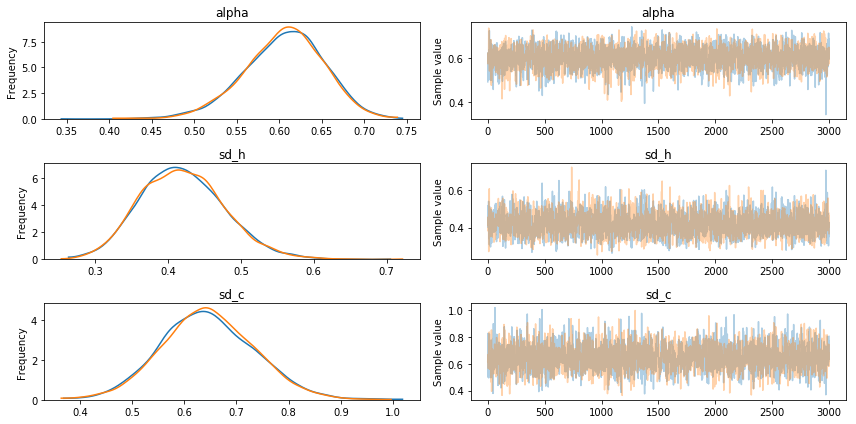

In [10]:
pm.traceplot(trace, varnames=['alpha', 'sd_h', 'sd_c']);

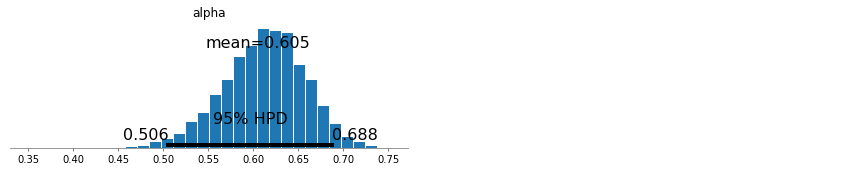

In [12]:
pm.plot_posterior(trace, varnames=['alpha']);

In [13]:
maxwz = max([sum(w) for w in weights])
N = len(weights)
wmat2 = np.zeros((N, N))
amat2 = np.zeros((N, N), dtype=int32)
for i, a in enumerate(adj):
    amat2[i, a] = 1
    wmat2[i, a] = weights[i]
    
value=np.asarray(np.random.randn(N,), dtype=theano.config.floatX)

print(np.sum(value*amat2, axis=1)/np.sum(wmat2, axis=1))

def mu_phi(value):
    N=len(weights)
    # Calculate mu based on average of neighbours 
    mu = np.array([np.sum(weights[i]*value[adj[i]])/Wplus[i] for i in range(N)])
    return mu

print(mu_phi(value))

[-0.21096216  0.68467193  0.81616094 -0.68980531 -0.63306254 -0.78480644
 -0.24032157  1.18346506 -0.38916838 -0.60336607 -0.196916   -0.6182781
  0.09924002 -0.53721971  0.61342446  0.30858036 -0.19620599  0.06715618
 -0.38628438  0.07069086  0.06822561  0.44185581  0.34747851  0.43238209
 -0.12037816  1.26812277 -0.09054728 -0.03066442 -0.11057126  0.21082661
 -0.08409481 -0.37160979 -0.33473641 -0.18899984 -0.33883535 -0.63944481
 -1.03216615  0.49602598 -0.66668095  0.07816179 -0.155381    0.3093644
  0.62190222  0.71219916  0.58065467 -0.29988818  0.02143003  0.51603167
 -0.17380775 -0.08114548  0.50811055  0.14642677 -0.11696796 -0.2269258
 -0.30287725  0.23670746]
[-0.21096216  0.68467193  0.81616094 -0.68980531 -0.63306254 -0.78480644
 -0.24032157  1.18346506 -0.38916838 -0.60336607 -0.196916   -0.6182781
  0.09924002 -0.53721971  0.61342446  0.30858036 -0.19620599  0.06715618
 -0.38628438  0.07069086  0.06822561  0.44185581  0.34747851  0.43238209
 -0.12037816  1.26812277 -0.0

In [14]:
import pymc3 as pm
import theano.tensor as tt
from theano import scan
import theano
floatX = "float32"

from pymc3.distributions import continuous
from pymc3.distributions import distribution

class CAR2(distribution.Continuous):
    """
    Conditional Autoregressive (CAR) distribution
    
    Parameters
    ----------
    k : tensor
       effect of lagged value on current value
    tau_e : tensor
       precision for innovations
    """

    def __init__(self, w, a, tau, *args, **kwargs):
        super(CAR2, self).__init__(*args, **kwargs)
        self.a = a = tt.as_tensor_variable(a)
        self.w = w = tt.as_tensor_variable(w)
        self.tau = tau*tt.sum(w, axis=1)
        self.mode = 0.
    
    def logp(self, x):
        tau = self.tau
        w = self.w
        a = self.a
        
        mu_w = tt.sum(x*a, axis=1)/tt.sum(w, axis=1)
        return tt.sum(continuous.Normal.dist(mu=mu_w, tau=tau).logp(x))

In [15]:
with pm.Model() as model:
    # Vague prior on intercept
    beta0 = pm.Normal('beta0', mu=0.0, tau=1.0e-5)
    # Vague prior on covariate effect
    beta1 = pm.Normal('beta1', mu=0.0, tau=1.0e-5)

    # Random effects (hierarchial) prior
    tau_h = pm.Gamma('tau_h', alpha=3.2761, beta=1.81)
    # Spatial clustering prior
    tau_c = pm.Gamma('tau_c', alpha=1.0, beta=1.0)

    # Regional random effects
    theta = pm.Normal('theta', mu=0.0, tau=tau_h, shape=N)
    
    mu_phi = CAR2('mu_phi', w=wmat2, a=amat2, tau=tau_c, shape=N)

    # Zero-centre phi
    phi = pm.Deterministic('phi', mu_phi-tt.mean(mu_phi))

    # Mean model
    mu = pm.Deterministic('mu', tt.exp(logE + beta0 + beta1*aff + theta + phi))

    # Likelihood
    Yi = pm.Poisson('Yi', mu=mu, observed=O)

    # Marginal SD of heterogeniety effects
    sd_h = pm.Deterministic('sd_h', tt.std(theta))
    # Marginal SD of clustering (spatial) effects
    sd_c = pm.Deterministic('sd_c', tt.std(phi))
    # Proportion sptial variance
    alpha = pm.Deterministic('alpha', sd_c/(sd_h+sd_c))
    
    trace = pm.sample(3e3, njobs=2, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 203.27:   8%|▊         | 16262/200000 [00:03<00:37, 4960.13it/s]
Convergence archived at 16500
Interrupted at 16,500 [8%]: Average Loss = 337
100%|██████████| 4000/4000.0 [02:02<00:00, 32.71it/s]


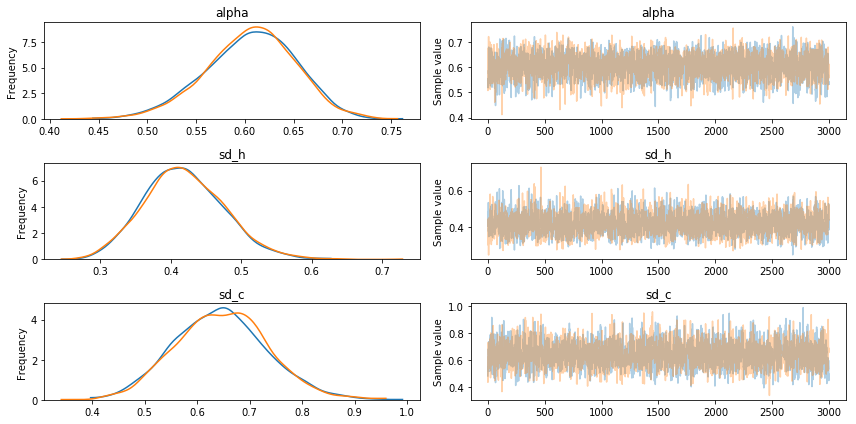

In [16]:
pm.traceplot(trace, varnames=['alpha', 'sd_h', 'sd_c']);

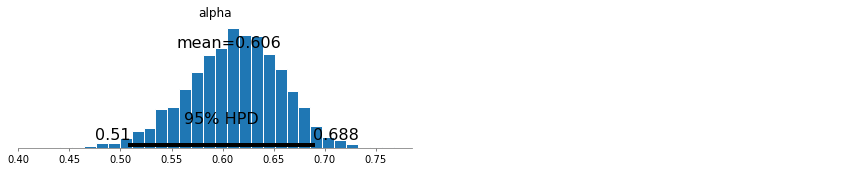

In [17]:
pm.plot_posterior(trace, varnames=['alpha']);

# `theano.scan` related

Populating the interactive namespace from numpy and matplotlib


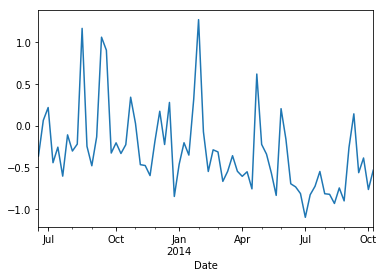

In [1]:
%pylab inline
import numpy as np
import theano
import theano.tensor as tt
import pymc3 as pm

import pandas_datareader as pdr

df = pdr.get_data_yahoo('AAPL')
data = df.Volume.resample("W-Mon").sum().astype("float32")
# whiten
data -= data.mean() 
data /= data.std()
data = data[180:250]
N = len(data)

fig = plt.figure()
data.plot()

In [2]:
def funcx(E, X0, A):
#         return x_m1 + a*e
    return A*X0 + E

x_m1 = data.iloc[0]
a = .05
e = np.random.randn(N-1)

# defining the tensor variables
X0 = tt.scalar("X0")
X0.tag.test_value = x_m1
A = tt.scalar("A")
A.tag.test_value = a
E = tt.vector("E")
E.tag.test_value = e

results, _ = theano.scan(fn=funcx, sequences=[E], non_sequences=[X0, A])
compute_elementwise = theano.function(inputs=[E, X0, A], outputs=results)

print(compute_elementwise(e, x_m1, a))

[ -4.05735173e-01   8.76313416e-01   6.74856580e-01  -1.67253212e+00
  -4.79419747e-01   8.85971784e-01  -1.20623701e-02  -3.68265605e-01
  -2.67602342e-02  -3.75749255e-02   2.57759312e+00  -3.41348981e-01
   4.54442878e-01  -7.09666544e-01  -6.07207196e-01  -4.39654116e-01
   4.38555944e-01   6.55757193e-01   5.97073273e-01   4.05433076e-01
   5.99582720e-01  -2.87574244e-01   1.10543181e+00   9.51717991e-01
  -7.55652256e-01  -2.34060186e-03   1.38362680e+00  -1.08106565e+00
  -2.28199392e+00   1.51903174e-01  -1.80298204e+00  -1.35922228e+00
  -1.71610290e+00  -9.04046272e-02  -2.23336966e-01  -2.00320456e-01
  -1.00664447e+00   9.17348096e-01   3.50816529e-01  -3.16520268e-01
  -1.28001885e+00   1.15210093e+00   5.55028477e-02   2.48167917e-01
  -1.12790627e+00   1.01668361e+00   1.50077052e-01  -8.84910839e-01
  -2.69379394e+00   4.49506953e-02  -1.40577444e+00  -7.28296306e-01
   1.14299417e+00   1.24858679e+00   3.70376224e-01   2.72184070e-01
  -7.73437806e-01   1.03461723e+00

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -92.793: 100%|██████████| 200000/200000 [01:49<00:00, 1832.15it/s]
Finished [100%]: Average ELBO = -92.74
100%|█████████▉| 4998/5000 [7:25:41<00:00, 18.46it/s]       /Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:265: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.686002063365, but should be close to 0.8. Try to increase the number of tuning steps.
  % (chain, mean_accept, target_accept))
100%|██████████| 5000/5000 [7:25:41<00:00,  5.35s/it]


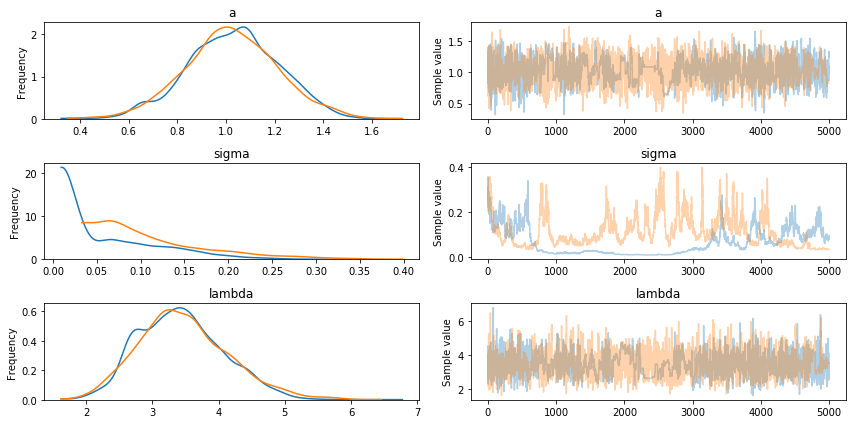

In [5]:
with pm.Model() as model:
    a = pm.Normal("a", 0, 1)
    sigma = pm.Exponential('sigma', 0.1, testval=.1)
    e = pm.Normal("e", 0, sigma, shape=(N-1,))
    
    x, _ = theano.scan(fn=funcx, sequences=[e], non_sequences=[data.iloc[0], a])
    x1 = pm.Deterministic('x1', x)
    
    lam = pm.Exponential('lambda', 5.0, testval=.1)
    y = pm.StudentT("y", mu=x1, lam=lam, nu=1, observed=data.values[1:]) # 
    trace = pm.sample(5000, tune=1000, njobs=2)

pm.traceplot(trace, varnames=['a','sigma','lambda']);

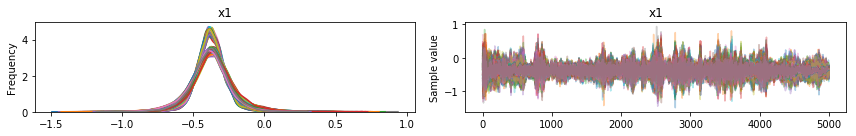

In [6]:
pm.traceplot(trace, varnames=['x1']);

# Model prediction using ppc and theano.shared

Populating the interactive namespace from numpy and matplotlib


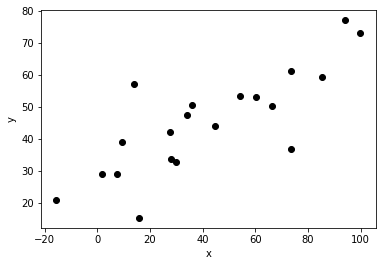

In [2]:
%pylab inline
import numpy as np
import pymc3 as pm
import theano.tensor as tt
#np.random.seed(42)
theta_true = (25, 0.5)
xdata = 100 * np.random.random(20)
ydata = theta_true[0] + theta_true[1] * xdata

# add scatter to points
xdata = np.random.normal(xdata, 10)
ydata = np.random.normal(ydata, 10)

from theano import shared
xdata_shared = shared(xdata)

plt.plot(xdata, ydata, 'ok')
plt.xlabel('x')
plt.ylabel('y');

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 4000/4000.0 [00:06<00:00, 576.51it/s]


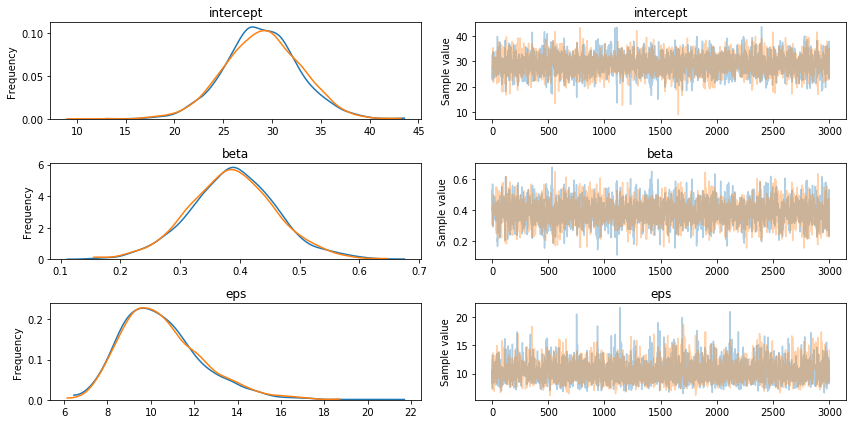

In [3]:
def loglike1(value):
    return -1.5 * tt.log(1 + value**2)
def loglike2(value):
    return -tt.log(tt.abs_(value))

with pm.Model() as model1:
#    alpha = pm.Uniform('intercept', -100, 100)
    alpha = pm.Normal('intercept', mu=0, sd=100)
    
    # Create custom densities, you must supply logp
    beta = pm.DensityDist('beta', loglike1, testval=0)
    eps = pm.DensityDist('eps', loglike2, testval=1)
    
    # Create likelihood
    like = pm.Normal('y_est', mu=alpha + beta * xdata_shared, sd=eps, observed=ydata)
    
    trace = pm.sample(3e3, njobs=2, tune=1000) # Make sure not to draw too many samples

pm.traceplot(trace);

In [4]:
xdata_oos=np.arange(-20, 120,1) #out of sample
xdata_shared.set_value(xdata_oos)
ppc = pm.sample_ppc(trace, model=model1, samples=500)

100%|██████████| 500/500 [00:01<00:00, 300.29it/s]


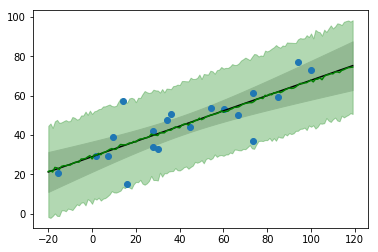

In [5]:
yppc = ppc['y_est'].mean(axis=0)
yppcstd=ppc['y_est'].std(axis=0)
plt.plot(xdata, ydata,'o');
intercept, beta = trace['intercept'][:,None], trace['beta'][:,None]
yfit = intercept + beta * xdata_oos
mu = yfit.mean(0)
sig = 2 * yfit.std(0)
plt.plot(xdata_oos, mu, '-k')
plt.fill_between(xdata_oos, mu - sig, mu + sig, color='lightgray')
plt.plot(xdata_oos, yppc, color="green")
plt.fill_between(xdata_oos, yppc - 2*yppcstd, yppc + 2*yppcstd, color='green', alpha=0.3)

# MvNormal Generation

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.5/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['standard_normal', 'cov']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


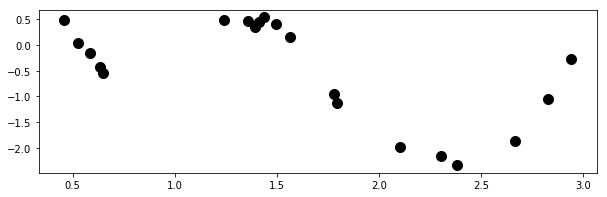

In [70]:
%pylab inline
import numpy as np
import pymc3 as pm
import theano
import theano.tensor as tt

np.random.seed(20170401)
n, n2 = 20, 100
X = np.sort(3*np.random.rand(n))[:,None]
Z = np.linspace(0, 4, n2)[:,None]

l_true, s2_f_true, s2_n_true = .3, 1., .1
with pm.Model() as model:
    # cov
    cov = pm.gp.cov.ExpQuad(1, l_true)
    # noise, epsilon
    K_noise = s2_n_true**2 * tt.eye(n)
    
# evaluate the covariance with the given hyperparameters
K1 = theano.function([], cov(X)+K_noise)()

# generate fake data from GP with white noise (with variance sigma2)
ymu = np.random.multivariate_normal(np.zeros(n), K1)

ax1 = plt.figure(figsize=(10,3))
plt.plot(X, ymu, 'ok', ms=10)

In [85]:
from theano.tensor.nlinalg import matrix_inverse
S_xz = cov(X,Z)
S_zz = cov(Z)
S_inv = matrix_inverse(cov(X) + K_noise)
m_post = theano.function([], tt.dot(tt.dot(S_xz.T, S_inv), ymu))()
S_post = theano.function([], S_zz - tt.dot(tt.dot(S_xz.T, S_inv), S_xz))()

In [127]:
from theano.tensor.slinalg import solve_lower_triangular as solve_lt
from theano.tensor.slinalg import solve_upper_triangular as solve_ut
from theano.tensor.slinalg import cholesky
L = tt.slinalg.cholesky(K)
alpha = solve_ut(L.T, solve_lt(L, ymu))
S_xz = cov(X,Z)
m_post = theano.function([], tt.dot(S_xz.T, alpha))()
v = solve_lt(L, S_xz)
S_post = theano.function([], S_zz - tt.dot(v.T, v))()
# S_chol = theano.function([], cholesky(S_zz - tt.dot(v.T, v)))()

In [110]:
Kx = cov(X, Z)
A = solve_lt(L, Kx)
V = solve_ut(L, ymu)
m_post = theano.function([], tt.dot(A.T, V))()
S_post = theano.function([], S_zz - tt.dot(A.T, A))()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: covariance is not positive-semidefinite.
  


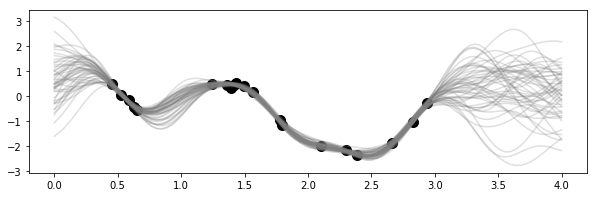

In [128]:
# generate fake data from GP with white noise (with variance sigma2)
ystim = np.random.multivariate_normal(m_post, S_post,50)

ax1 = plt.figure(figsize=(10,3))
ax1 = plt.figure(figsize=(10,3))
plt.plot(X, ymu, 'ok', ms=10)
plt.plot(Z, ystim.T, c='gray',alpha=.25, ms=10);

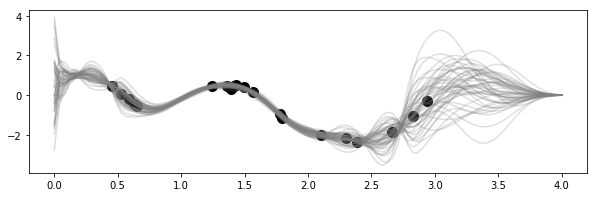

In [129]:
standard_normal = np.random.standard_normal((50,n2))
import scipy
jitter = 1e-6
x = S_post + jitter* np.eye(n2)
z = scipy.linalg.cholesky(x, lower=True).astype(x.dtype)

S_chol = z
ystim = m_post + np.dot(standard_normal, S_chol)

ax1 = plt.figure(figsize=(10,3))
ax1 = plt.figure(figsize=(10,3))
plt.plot(X, ymu, 'ok', ms=10)
plt.plot(Z, ystim.T, c='gray',alpha=.25, ms=10);